# Algorithms Performance Analysis

## Importing Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DSSE import DroneSwarmSearch
import seaborn as sns
import csv

## Importing Necessary Modules

In [31]:
from config import get_config
from test_policy import get_model, get_random_speed_vector, play_one_episode

## Load Data

In [3]:
DATA_FOLDER = "data"
def load_data(config, algorithm):
    statistics = pd.read_csv(
        f"{DATA_FOLDER}/statistics_{config}_{algorithm}.csv"
    )
    return statistics

## Plotting Learning Curves

In [60]:
def plot_learning_curve(statistics, config, algorithm):
    num_drones = config.n_drones
    disperse_constant = config.disperse_constant
    plt.style.use("seaborn-v0_8-darkgrid")
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot mean rewards considering a window of 500 episodes
    ax1.plot(
        statistics["episode"],
        statistics["rewards"].rolling(500).mean(),
        "r-",
        label="Mean Rewards",
    )
    ax1.set_ylabel("Mean Rewards")

    # Divide actions by the number of drones to get the mean number of actions per drone
    statistics["actions"] = statistics["actions"] / num_drones

    ax2.plot(
        statistics["episode"],
        statistics["actions"].rolling(500).mean(),
        "b-",
        label="Mean Actions",
    )
    ax2.set_ylabel("Mean Actions")

    # Legend, title and labels
    fig.legend()
    plt.title(f"Learning Curve - {algorithm} ({num_drones = }, {disperse_constant = })")
    ax1.set_xlabel("Episodes")
    plt.grid()
    algorithm_name = "_".join(algorithm.split(" ")).lower()
    plt.savefig(f"imgs/learning_curve_nd{num_drones}_dc{disperse_constant}_{algorithm_name}.png", dpi=300)
    plt.show()

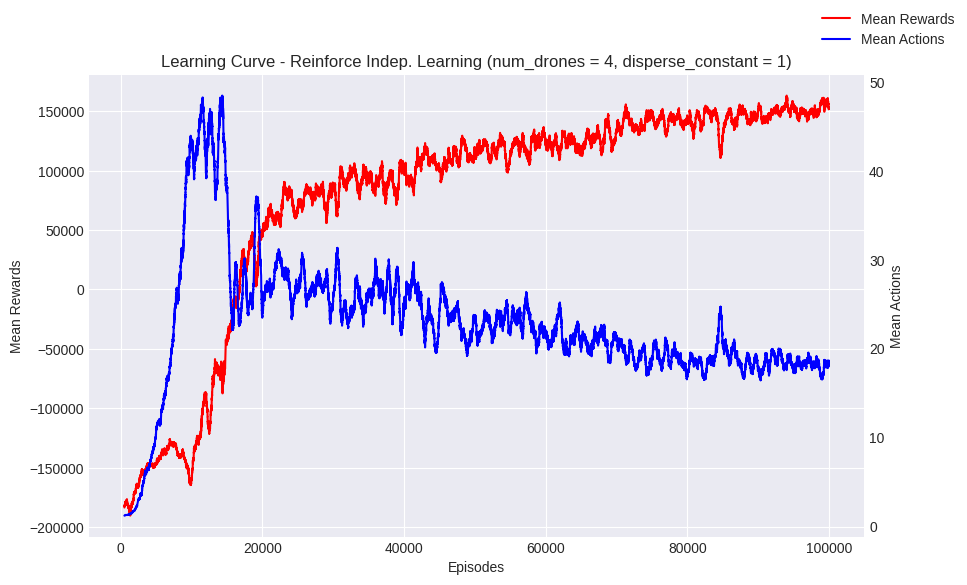

In [62]:
config_2 = get_config(2)
stat_rf_il = load_data(config_2, "reinforce_il")
plot_learning_curve(stat_rf_il, config_2, "Reinforce Indep. Learning")

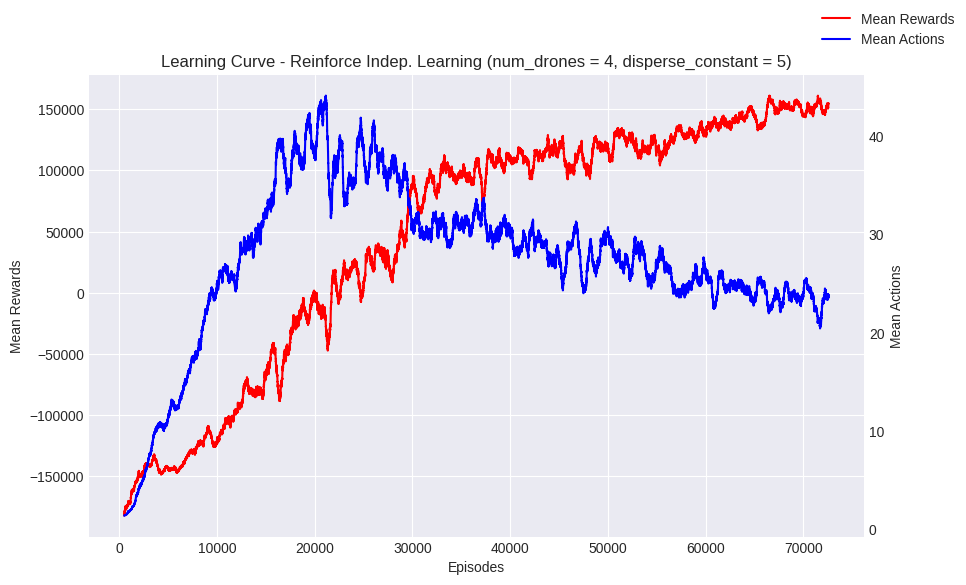

In [63]:
config_4 = get_config(4)
stat_rf_il = load_data(config_4, "reinforce_il")
plot_learning_curve(stat_rf_il, config_4, "Reinforce Indep. Learning")

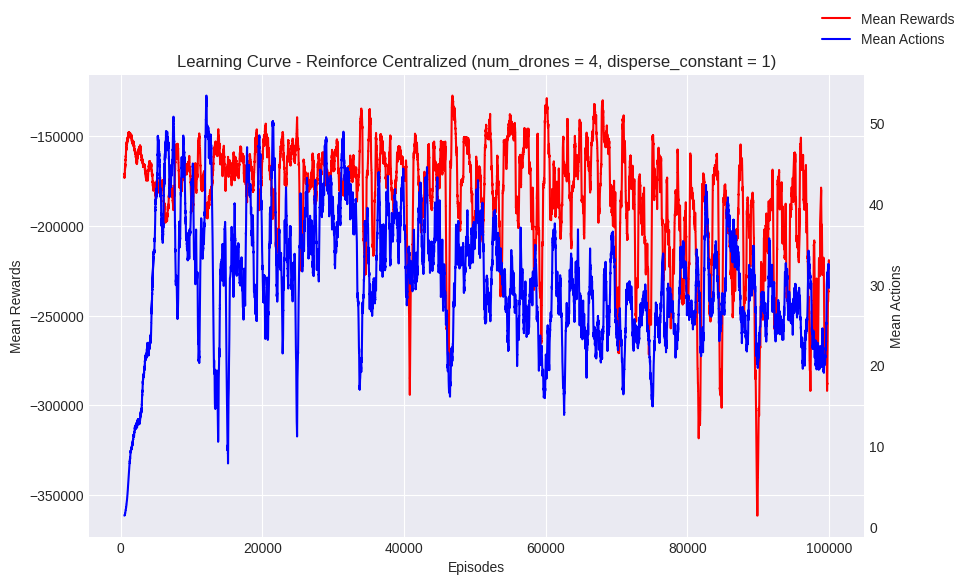

In [64]:
stat_rf = load_data(config_2, "reinforce")
plot_learning_curve(stat_rf, config_2, "Reinforce Centralized")

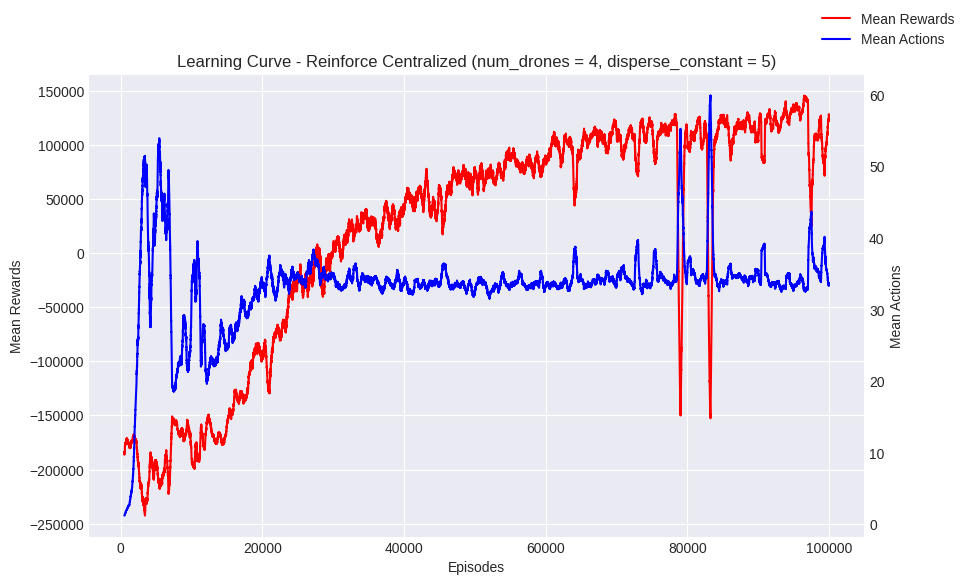

In [65]:
stat_rf = load_data(config_4, "reinforce")
plot_learning_curve(stat_rf, config_4, "Reinforce Centralized")

##  Comparing Algorithms - Collecting Data

In [32]:
def instantiate_env(config):
    env = DroneSwarmSearch(
        grid_size=config.grid_size,
        render_mode="ansi",
        render_grid=False,
        render_gradient=False,
        n_drones=config.n_drones,
        person_initial_position=config.person_initial_position,
        disperse_constant=config.disperse_constant,
        timestep_limit=config.timestep_limit,
    )
    return env

In [16]:
def collect_algorithms_data(config_number: int):
    config = get_config(config_number)
    env = instantiate_env(config)

    output_file = (
        f"{DATA_FOLDER}/results_{config}.csv"
    )
    with open(output_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            [
                "Reinforce Rewards",
                "Reinforce Steps",
                "Reinforce Found",
                "Greedy Rewards",
                "Greedy Steps",
                "Greedy Found",
            ]
        )
        n_episodes = 10_000
        for i in range(n_episodes):
            print(f"In episode {i}/{n_episodes} - {config_number}")
            (
                reinforce_reward,
                reinforce_steps,
                reinforce_found,
            ) = run_one_episode_reinforce(env, nn, config_number)
            (
                greedy_reward,
                greedy_steps,
                greedy_found,
            ) = run_one_episode_greedy(env, config_number)

            writer.writerow(
                [
                    reinforce_reward,
                    reinforce_steps,
                    reinforce_found,
                    greedy_reward,
                    greedy_steps,
                    greedy_found,
                ]
            )

    print(f"Data saved to {output_file}")